# TF-Gene interaction analysis

In this we study if TF-genes interactions can be directly recovered from pre-processed data. The code in here was used to generate the results in section VI of 'Parameter-free representations outperform single-cell foundation models on downstream benchmarks'.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import zscore
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import sctop as top
from transcriptformer.datasets import tabula_sapiens
import requests
from io import StringIO
import mygene
from typing import Tuple, Optional

We would like first to change genes names from Ensembl IDs to gene symbols and then pre-process each cell independently using scTOP.

In [2]:
print("Loading data...")
adata = tabula_sapiens(
    tissue='bone_marrow', 
    version="v2", 
    path="/projectnb/biophys/Huan/tabula_v2/bone_marrow.h5ad", 
    force_download=False
)

print("Mapping Ensembl IDs to gene symbols...")

def map_ensembl_to_symbol(ensembl_ids):
    """
    Maps Ensembl IDs to gene symbols using MyGene.info API.
    Returns a dictionary: {ensembl_id: gene_symbol}
    """
    mg = mygene.MyGeneInfo()
    
    results = mg.querymany(
        ensembl_ids, 
        scopes='ensembl.gene',
        fields='symbol',
        species='human',
        returnall=True
    )
    
    mapping = {}
    for hit in results['out']:
        ensembl = hit['query']
        symbol = hit.get('symbol', ensembl)
        mapping[ensembl] = symbol
    
    print(f"Mapped {len(mapping)} / {len(ensembl_ids)} genes")
    return mapping

ensembl_ids = adata.var_names.tolist()
gene_mapping = map_ensembl_to_symbol(ensembl_ids)

adata.var['gene_symbol'] = [gene_mapping.get(eid, eid) for eid in adata.var_names]

print("Running scTOP processing...")
input_df = adata.to_df().T 
processed_df = top.process(input_df, average=False)

processed_df.index = [gene_mapping.get(eid, eid) for eid in processed_df.index]

Loading data...


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Mapping Ensembl IDs to gene symbols...


11 input query terms found dup hits:	[('ENSG00000175711', 2), ('ENSG00000226519', 2), ('ENSG00000227110', 2), ('ENSG00000228566', 2), ('E
440 input query terms found no hit:	['ENSG00000002079', 'ENSG00000132832', 'ENSG00000148362', 'ENSG00000168078', 'ENSG00000176659', 'ENS


Mapped 26167 / 26167 genes
Running scTOP processing...


We then compute gene-gene interactions and use STRING database to validate our results.

In [3]:
def get_string_interactions(protein_name, species=9606, score_threshold=400, limit=100):
    """
    Fetches known protein-protein interactions from STRING database.
    
    Parameters:
    -----------
    protein_name : str
        Gene symbol (e.g., 'FOXM1')
    species : int
        NCBI taxonomy ID (9606 for human)
    score_threshold : int
        Minimum combined score (0-1000), 400 is medium confidence
    
    Returns:
    --------
    set : Set of interacting gene symbols
    """

    string_api_url = "https://string-db.org/api/tsv/network"
    
    params = {
        "identifiers": protein_name,
        "species": species,
        "caller_identity": "python_script",
        "limit": limit, 
        "required_score": score_threshold
    }
    
    try:
        response = requests.get(string_api_url, params=params)
        response.raise_for_status()
        
        df = pd.read_csv(StringIO(response.text), sep='\t')
        
        df = df[df['score'] >= score_threshold / 1000.0]
        
        interactors = set()
        for _, row in df.iterrows():
            pref_name_a = row.get('preferredName_A', '')
            pref_name_b = row.get('preferredName_B', '')
            
            if pref_name_a != protein_name:
                interactors.add(pref_name_a)
            if pref_name_b != protein_name:
                interactors.add(pref_name_b)
        
        print(f"Found {len(interactors)} STRING interactions for {protein_name} (score >= {score_threshold})")
        return interactors
    
    except Exception as e:
        print(f"Error fetching STRING data: {e}")
        return set()

def calculate_gene_interactions_auto(
    processed_df,
    target_tf,
    quantile_range=(0.7, 0.95),
    min_expr_range=(0.05, 0.2),
    optimization_metric='significant_genes',  # 'significant_genes' or 'mean_z_score'
    significance_threshold=0.05,
    min_cells_required=20,
    search_resolution=5,
    verbose=True
):
    """
    Self-tuning version that automatically finds optimal quantile and min_expression_freq.
    
    Parameters:
    -----------
    processed_df : pd.DataFrame
        Gene expression matrix (genes × cells)
    target_tf : str
        Target transcription factor
    quantile_range : tuple
        (min, max) range for TF activation quantile to search
    min_expr_range : tuple
        (min, max) range for minimum expression frequency to search
    optimization_metric : str
        'significant_genes' - maximize number of q < threshold genes
        'mean_z_score' - maximize mean Z-score of significant genes
        'top_100_z' - maximize mean Z-score of top 100 genes
    significance_threshold : float
        Q-value threshold for counting significant genes
    min_cells_required : int
        Minimum TF-active cells required
    search_resolution : int
        Number of points to test in each dimension (higher = slower but more precise)
    verbose : bool
        Print optimization progress
        
    Returns:
    --------
    results_df : pd.DataFrame
        Gene interaction results with optimal parameters
    optimal_params : dict
        The optimal parameters found
    """
    
    if target_tf not in processed_df.index:
        raise ValueError(f"{target_tf} not found in processed_df.index")
    
    quantiles = np.linspace(quantile_range[0], quantile_range[1], search_resolution)
    min_exprs = np.linspace(min_expr_range[0], min_expr_range[1], search_resolution)
    
    best_score = -np.inf
    best_params = None
    best_results = None
    
    if verbose:
        print(f"Optimizing for {target_tf}...")
        print(f"Testing {len(quantiles)} × {len(min_exprs)} = {len(quantiles) * len(min_exprs)} parameter combinations\n")
    
    for q in quantiles:
        for min_e in min_exprs:
            try:
                results = _calculate_interactions_core(
                    processed_df, target_tf, q, min_e, min_cells_required
                )
                
                if results is None or len(results) == 0:
                    continue
                
                significant = results[results['q_value'] < significance_threshold]
                
                if optimization_metric == 'significant_genes':
                    score = len(significant)
                elif optimization_metric == 'mean_z_score':
                    score = significant['Z_score'].mean() if len(significant) > 0 else 0
                elif optimization_metric == 'top_100_z':
                    top_genes = results.nlargest(100, 'Z_score')
                    score = top_genes['Z_score'].mean() if len(top_genes) > 0 else 0
                else:
                    raise ValueError(f"Unknown metric: {optimization_metric}")
                
                if score > best_score:
                    best_score = score
                    best_params = {'quantile': q, 'min_expression_freq': min_e}
                    best_results = results
                    
                    if verbose:
                        n_sig = len(significant)
                        mean_z = significant['Z_score'].mean() if len(significant) > 0 else 0
                        print(f"New best: q={q:.3f}, min_expr={min_e:.3f} → "
                              f"{n_sig} significant genes (mean Z={mean_z:.2f})")
                        
            except Exception as e:
                if verbose:
                    print(f"Failed for q={q:.3f}, min_expr={min_e:.3f}: {e}")
                continue
    
    if best_params is None:
        raise ValueError("No valid parameter combinations found")
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"Optimal parameters:")
        print(f"  Quantile: {best_params['quantile']:.3f}")
        print(f"  Min expression freq: {best_params['min_expression_freq']:.3f}")
        n_sig = len(best_results[best_results['q_value'] < significance_threshold])
        print(f"  Significant genes (q<{significance_threshold}): {n_sig}")
        print(f"  Total genes analyzed: {len(best_results)}")
        print(f"{'='*60}\n")
    
    return best_results, best_params


def _calculate_interactions_core(
    processed_df,
    target_tf,
    quantile,
    min_expression_freq,
    min_cells_required
):
    """Core calculation function (same as your original)"""
    
    n_cells = processed_df.shape[1]
    
    # Define TF-active cells
    tf_scores = processed_df.loc[target_tf]
    threshold = np.quantile(tf_scores, quantile)
    active_cells = tf_scores > threshold
    n_active = active_cells.sum()
    
    if n_active < min_cells_required:
        return None
    
    gene_expressed = processed_df > 0
    
    gene_freq = gene_expressed.sum(axis=1) / n_cells
    valid_genes = gene_freq >= min_expression_freq
    
    if valid_genes.sum() < 100:
        return None
    
    gene_expressed_filtered = gene_expressed[valid_genes]
    
    p_gene = gene_expressed_filtered.sum(axis=1) / n_cells
    p_gene_given_tf = gene_expressed_filtered.loc[:, active_cells].sum(axis=1) / n_active
    
    epsilon = 1e-10
    pmi = np.log((p_gene_given_tf + epsilon) / (p_gene + epsilon))
    
    z_scores = zscore(pmi, nan_policy="omit")
    
    pvals = 2 * (1 - stats.norm.cdf(np.abs(z_scores)))
    pvals_clean = np.nan_to_num(pvals, nan=1.0)
    
    _, qvals, _, _ = multipletests(pvals_clean, method="fdr_bh")
    
    results_df = pd.DataFrame({
        "gene": gene_expressed_filtered.index,
        "PMI": pmi,
        "Z_score": z_scores,
        "p_value": pvals_clean,
        "q_value": qvals,
        "p_gene": p_gene,
        "p_gene_given_tf": p_gene_given_tf,
        "freq_overall": gene_freq[valid_genes],
        "freq_in_active": gene_expressed_filtered.loc[:, active_cells].sum(axis=1) / n_active
    })
    
    results_df = results_df[results_df["gene"] != target_tf]
    results_df = results_df[results_df["Z_score"] > 0]
    
    return results_df


def plot_genes(results_df, target_tf, q_threshold=0.05, top_n=15, 
                            string_interactors=None, output_path=None):
    """
    Plots the PMI spectrum exactly like TranscriptFormer Fig 5A.
    Highlights genes validated by STRING in red.
    """
    df = results_df.copy()
    
    safe_p = np.clip(df["p_value"], 1e-300, 1.0)
    df["neg_log_p"] = -np.log10(safe_p)
    
    df = df.reset_index(drop=True)
    df["x_idx"] = range(len(df))
    
    significant = df[df["q_value"] < q_threshold].copy()
    
    if not significant.empty:
        p_cutoff = significant["p_value"].max()
        y_threshold = -np.log10(p_cutoff)
    else:
        y_threshold = -np.log10(0.05) 

    if string_interactors is not None:
        df['in_string'] = df['gene'].isin(string_interactors)
        significant['in_string'] = significant['gene'].isin(string_interactors)
        n_validated = significant['in_string'].sum()
        print(f"\nSTRING validation: {n_validated}/{len(significant)} significant genes validated")
    else:
        df['in_string'] = False
        significant['in_string'] = False
        n_validated = 0
    
    if string_interactors is not None and len(significant[significant['in_string']]) > 0:
        top_validated = significant[significant['in_string']].nlargest(
            min(top_n, len(significant[significant['in_string']])), 
            "neg_log_p"
        )
        top_other = significant[~significant['in_string']].nlargest(
            max(0, top_n - len(top_validated)), 
            "neg_log_p"
        )
        top_hits = pd.concat([top_validated, top_other])
    else:
        top_hits = significant.nlargest(min(top_n, len(significant)), "neg_log_p")
    
    n_predicted = len(significant)
    print(f"Significant interactions (q < {q_threshold}): {n_predicted}")
    
    fig, ax = plt.subplots(figsize=(12, 10), dpi=300)
    
    ax.scatter(
        df["x_idx"], 
        df["neg_log_p"], 
        c="#E0E0E0", 
        s=2, 
        alpha=0.6, 
        edgecolors='none',
        rasterized=True,
        zorder=1
    )
    
    sig_not_string = significant[~significant['in_string']]
    if len(sig_not_string) > 0:
        ax.scatter(
            sig_not_string["x_idx"],
            sig_not_string["neg_log_p"],
            c="#909090", 
            s=8,
            alpha=0.7,
            edgecolors='none',
            zorder=2
        )
    
    sig_in_string = significant[significant['in_string']]
    if len(sig_in_string) > 0:
        legend_label = f'STRING validated ({n_validated}/{n_predicted})'
        
        ax.scatter(
            sig_in_string["x_idx"],
            sig_in_string["neg_log_p"],
            c='#D62728', 
            s=12,
            alpha=0.8,
            edgecolors='black',
            linewidth=0.3,
            zorder=3,
            label=legend_label
        )
    
    if not significant.empty:
        ax.axhline(
            y=y_threshold, 
            color='black', 
            linestyle='--', 
            linewidth=0.8, 
            alpha=0.5, 
            zorder=0,
            label=f'FDR < {q_threshold}'
        )

    for idx, row in top_hits.iterrows():
        x = row["x_idx"]
        y = row["neg_log_p"]
        gene = row["gene"]
        is_string = row['in_string']
        
        ax.plot([x, x], [0, y], 
                color='#D62728' if is_string else '#505050', 
                alpha=0.4, 
                linewidth=0.6,
                zorder=2)
        
        ax.scatter(x, y, 
                   c='#D62728' if is_string else '#505050',
                   s=15, 
                   zorder=4, 
                   edgecolors='white', 
                   linewidth=0.8)
        
        ax.text(x, y + 0.15, gene, 
                ha='left', 
                va='bottom',
                fontsize=11, 
                rotation=45,
                color='black',
                fontweight='bold' if is_string else 'normal',
                zorder=5)
    
    ax.set_ylabel(r"$-\log_{10}(P)$", fontsize=16, fontweight='normal')
    ax.set_xlabel("Gene", fontsize=16, fontweight='normal')
    
    ax.text(0.01, 0.98, target_tf, 
            transform=ax.transAxes,
            fontsize=16, 
            fontweight='bold',
            va='top',
            ha='left')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-20, len(df) + 20)
    ax.set_ylim(bottom=0, top=ax.get_ylim()[1] * 1.15) 
    
    ax.set_xticks([])
    
    if string_interactors is not None and len(sig_in_string) > 0:
        ax.legend(loc='lower right', frameon=False, fontsize=14)
    
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    plt.show()
    
    validation_stats = {
        'total_significant': len(significant),
        'string_validated': n_validated,
        'validation_rate': n_validated / len(significant) if len(significant) > 0 else 0
    }
    
    return significant, validation_stats


Analyzing E2F8
Optimizing for E2F8...
Testing 10 × 10 = 100 parameter combinations

New best: q=0.500, min_expr=0.010 → 8 significant genes (mean Z=3.70)
New best: q=0.500, min_expr=0.031 → 11 significant genes (mean Z=4.11)
New best: q=0.500, min_expr=0.052 → 16 significant genes (mean Z=4.10)
New best: q=0.550, min_expr=0.052 → 17 significant genes (mean Z=4.03)
New best: q=0.700, min_expr=0.052 → 22 significant genes (mean Z=3.99)
New best: q=0.700, min_expr=0.073 → 33 significant genes (mean Z=3.90)
New best: q=0.750, min_expr=0.073 → 45 significant genes (mean Z=3.84)

Optimal parameters:
  Quantile: 0.750
  Min expression freq: 0.073
  Significant genes (q<0.05): 45
  Total genes analyzed: 4585


Fetching STRING interactions for E2F8...
Found 156 STRING interactions for E2F8 (score >= 400)

STRING validation: 36/45 significant genes validated
Significant interactions (q < 0.05): 45


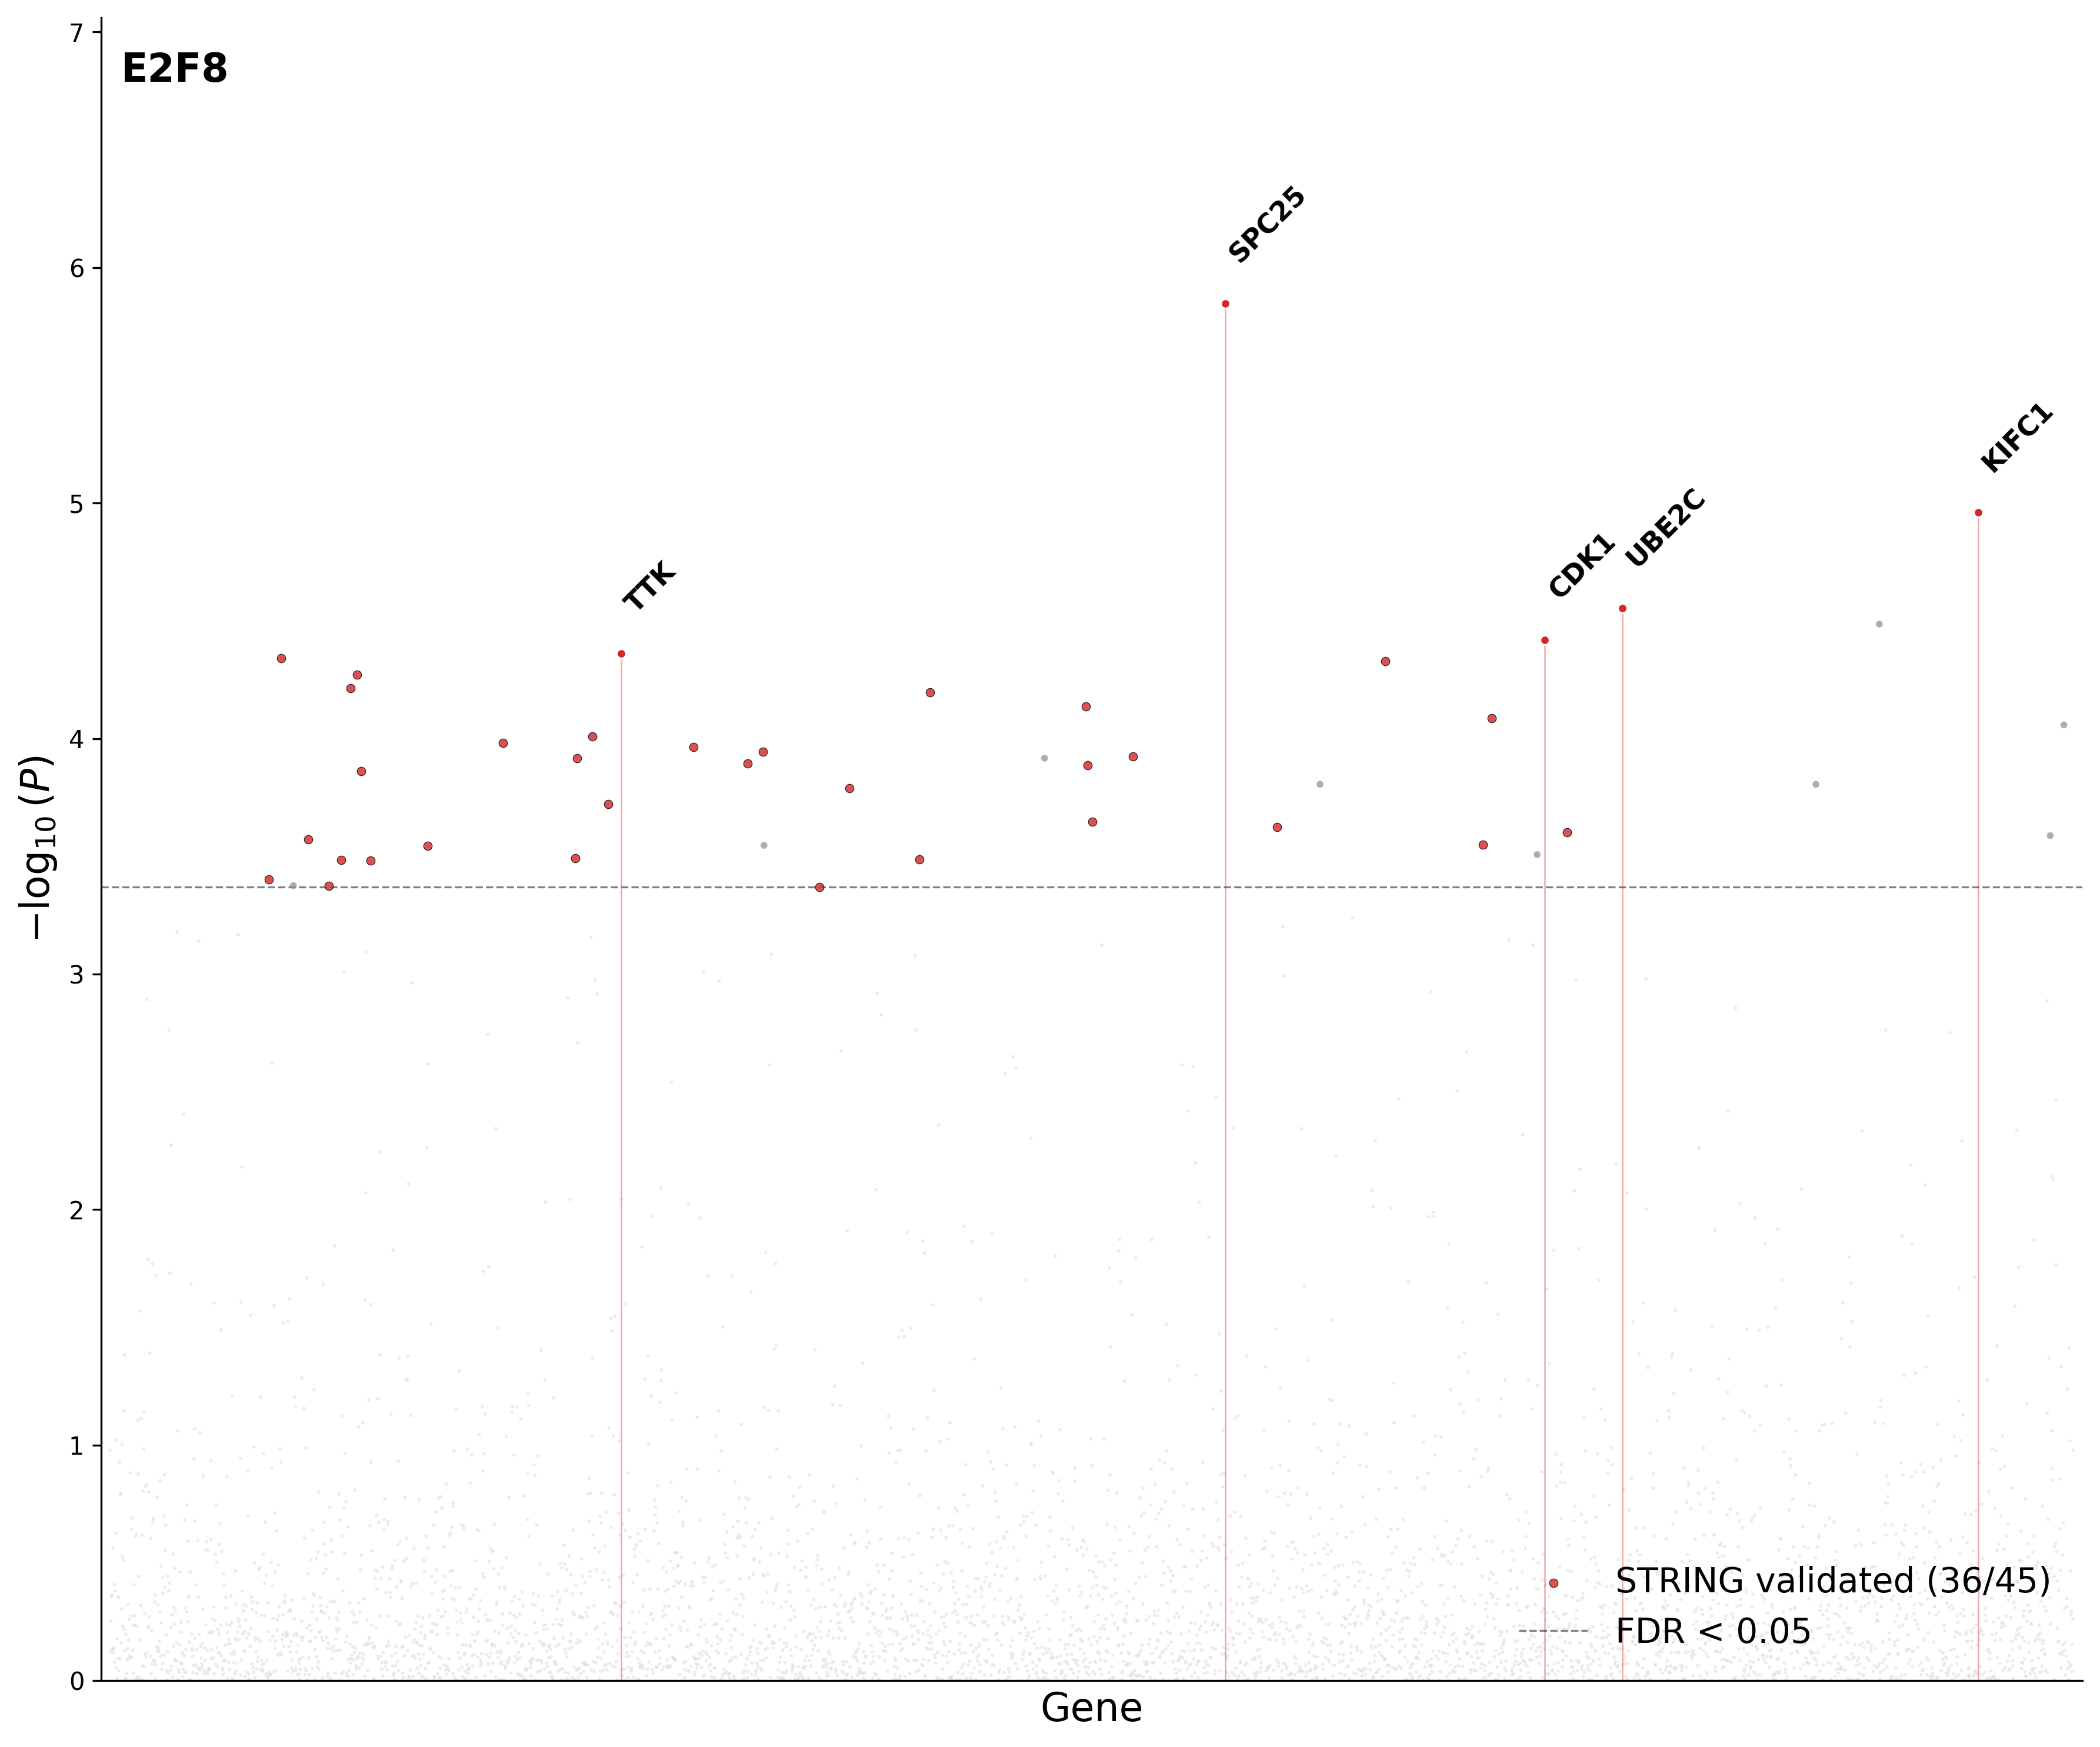


Results Summary for E2F8
Total significant genes (q < 0.05): 45
STRING-validated predictions: 36
Validation rate: 80.0%

Full results saved to: E2F8_interactions.csv

Analyzing FOXM1
Optimizing for FOXM1...
Testing 10 × 10 = 100 parameter combinations

New best: q=0.500, min_expr=0.010 → 2 significant genes (mean Z=3.69)
New best: q=0.500, min_expr=0.031 → 14 significant genes (mean Z=3.92)
New best: q=0.500, min_expr=0.052 → 22 significant genes (mean Z=3.94)
New best: q=0.550, min_expr=0.052 → 40 significant genes (mean Z=3.93)
New best: q=0.600, min_expr=0.052 → 58 significant genes (mean Z=3.93)
New best: q=0.650, min_expr=0.052 → 61 significant genes (mean Z=4.01)
New best: q=0.950, min_expr=0.052 → 76 significant genes (mean Z=3.84)

Optimal parameters:
  Quantile: 0.950
  Min expression freq: 0.052
  Significant genes (q<0.05): 76
  Total genes analyzed: 5517


Fetching STRING interactions for FOXM1...
Found 379 STRING interactions for FOXM1 (score >= 400)

STRING validation: 6

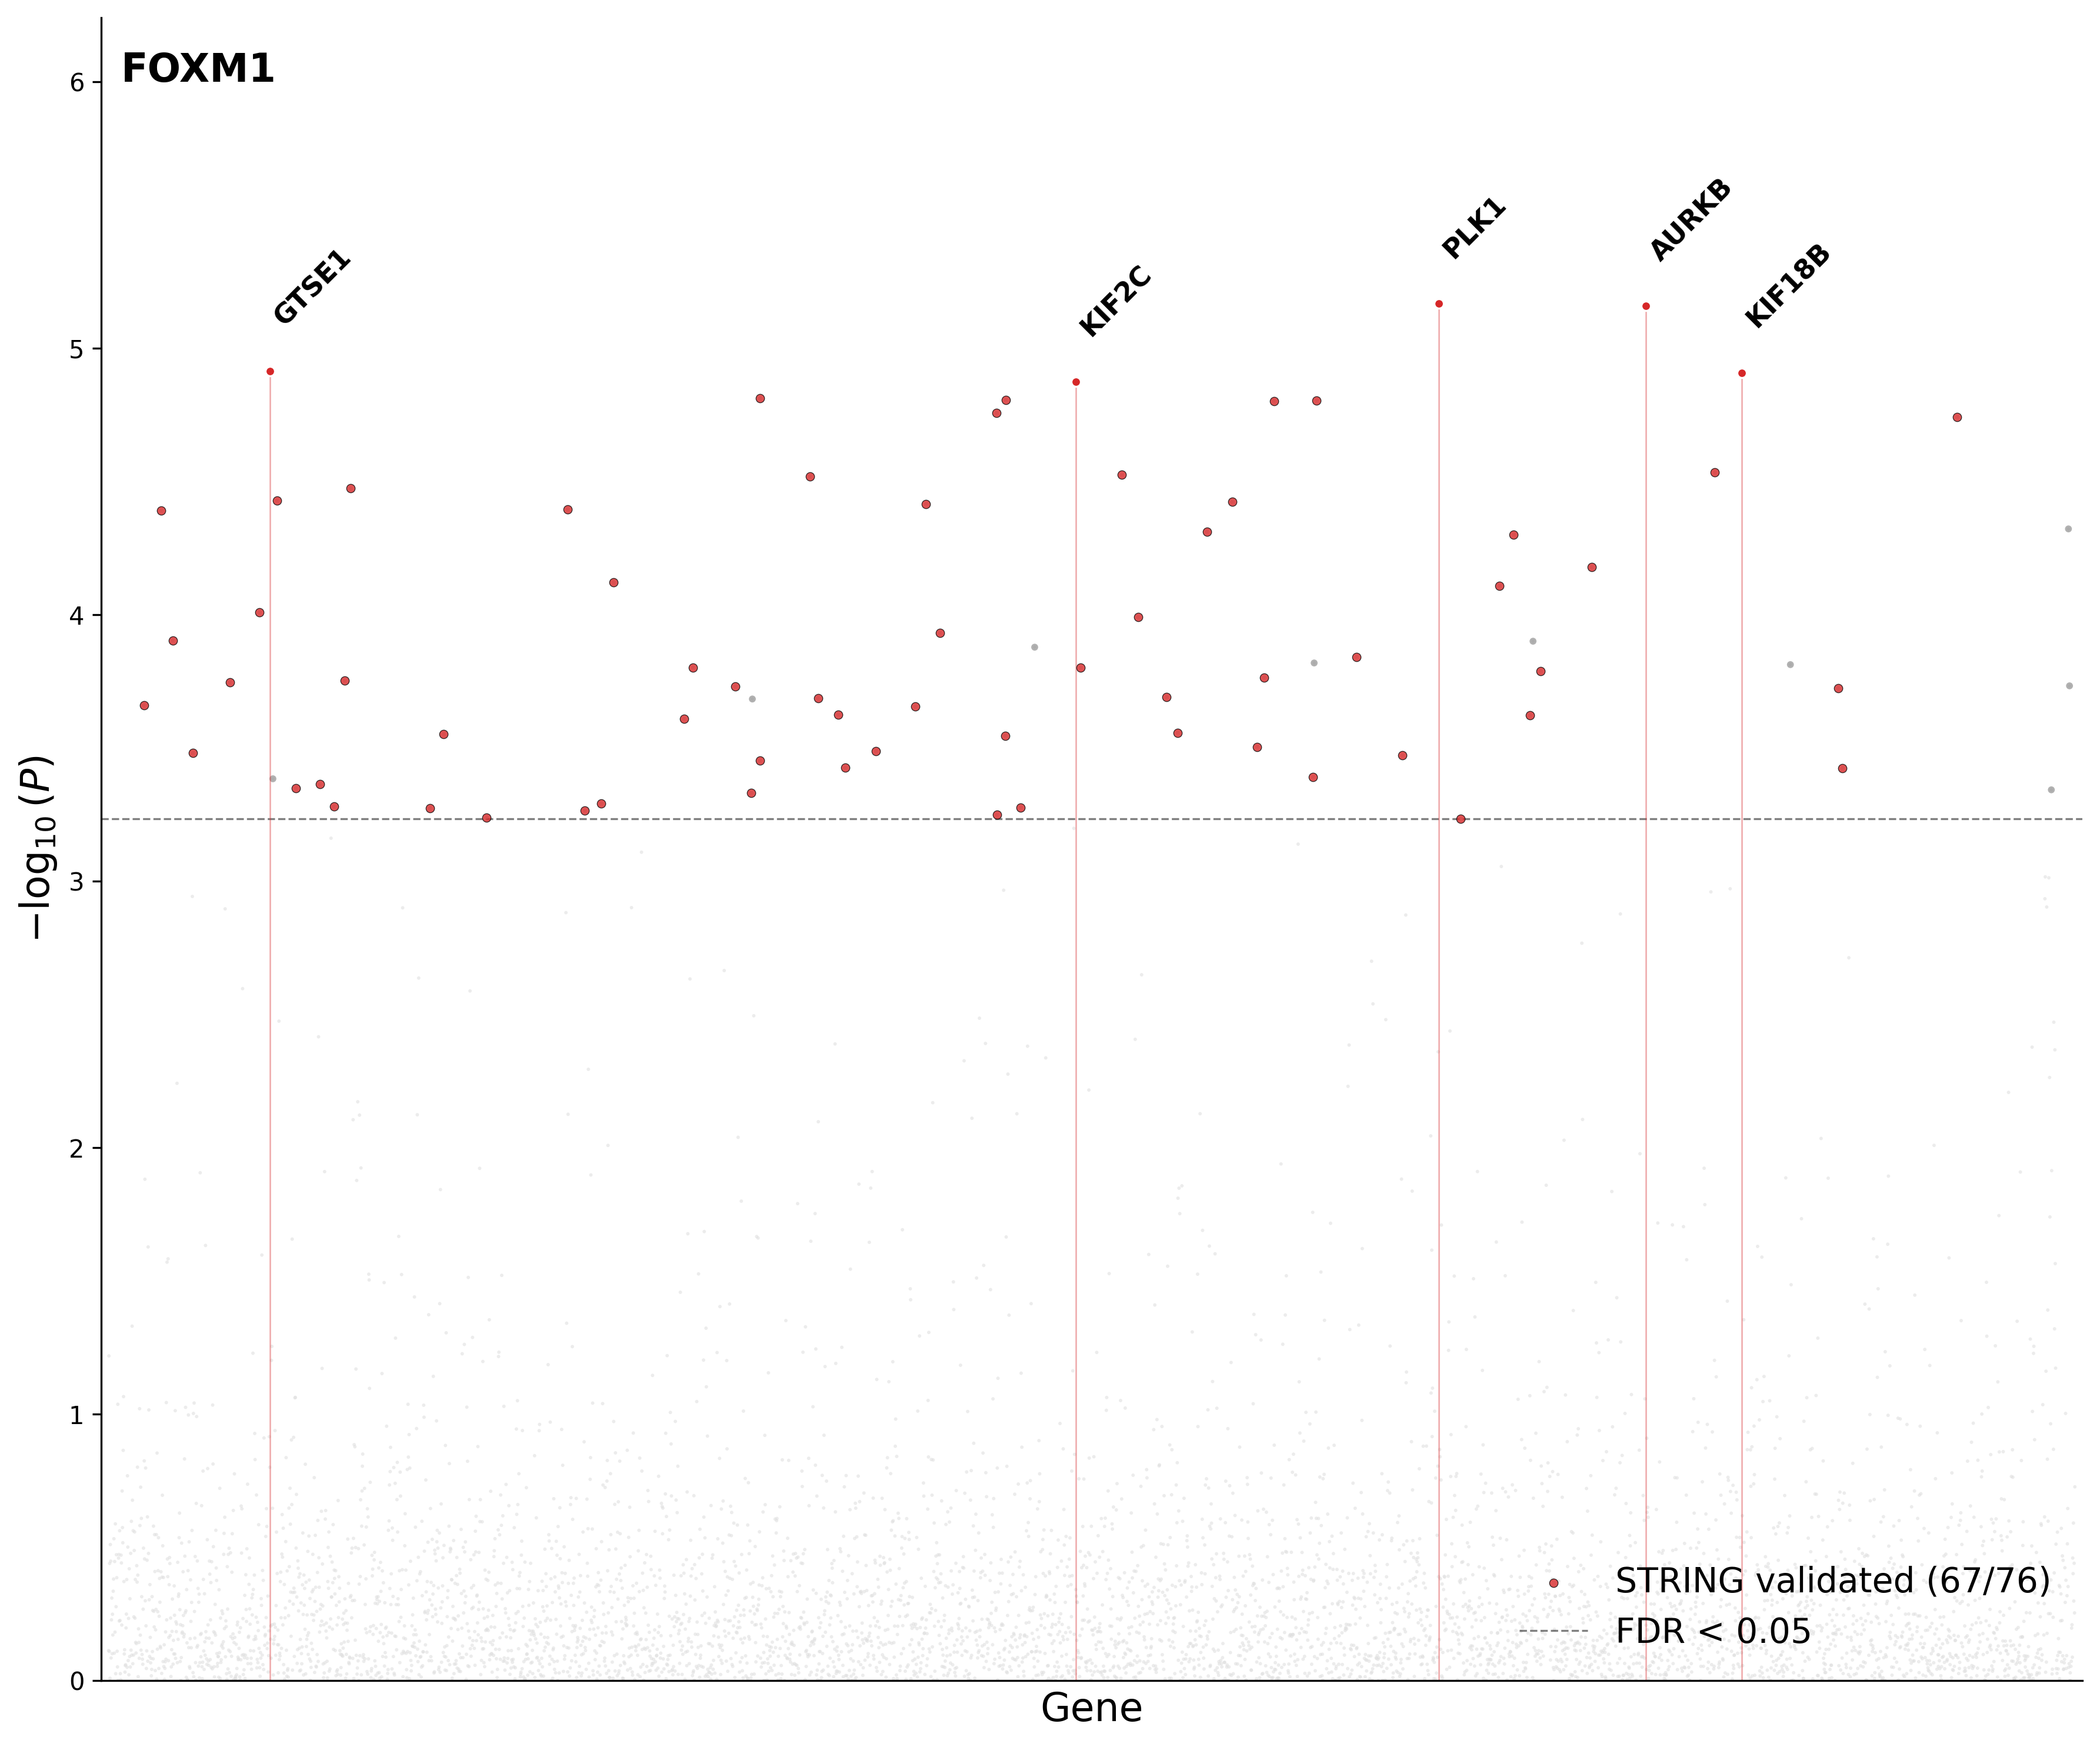


Results Summary for FOXM1
Total significant genes (q < 0.05): 76
STRING-validated predictions: 67
Validation rate: 88.2%

Full results saved to: FOXM1_interactions.csv

Analyzing SPIB
Optimizing for SPIB...
Testing 10 × 10 = 100 parameter combinations

New best: q=0.500, min_expr=0.010 → 0 significant genes (mean Z=0.00)
New best: q=0.800, min_expr=0.031 → 1 significant genes (mean Z=3.90)
New best: q=0.800, min_expr=0.073 → 5 significant genes (mean Z=3.87)
New best: q=0.800, min_expr=0.094 → 6 significant genes (mean Z=3.98)
New best: q=0.800, min_expr=0.116 → 7 significant genes (mean Z=4.06)
New best: q=0.800, min_expr=0.137 → 10 significant genes (mean Z=4.01)
New best: q=0.850, min_expr=0.052 → 21 significant genes (mean Z=3.88)
New best: q=0.850, min_expr=0.073 → 25 significant genes (mean Z=3.96)
New best: q=0.900, min_expr=0.031 → 28 significant genes (mean Z=3.88)
New best: q=0.900, min_expr=0.052 → 34 significant genes (mean Z=3.98)
New best: q=0.900, min_expr=0.073 → 39 si

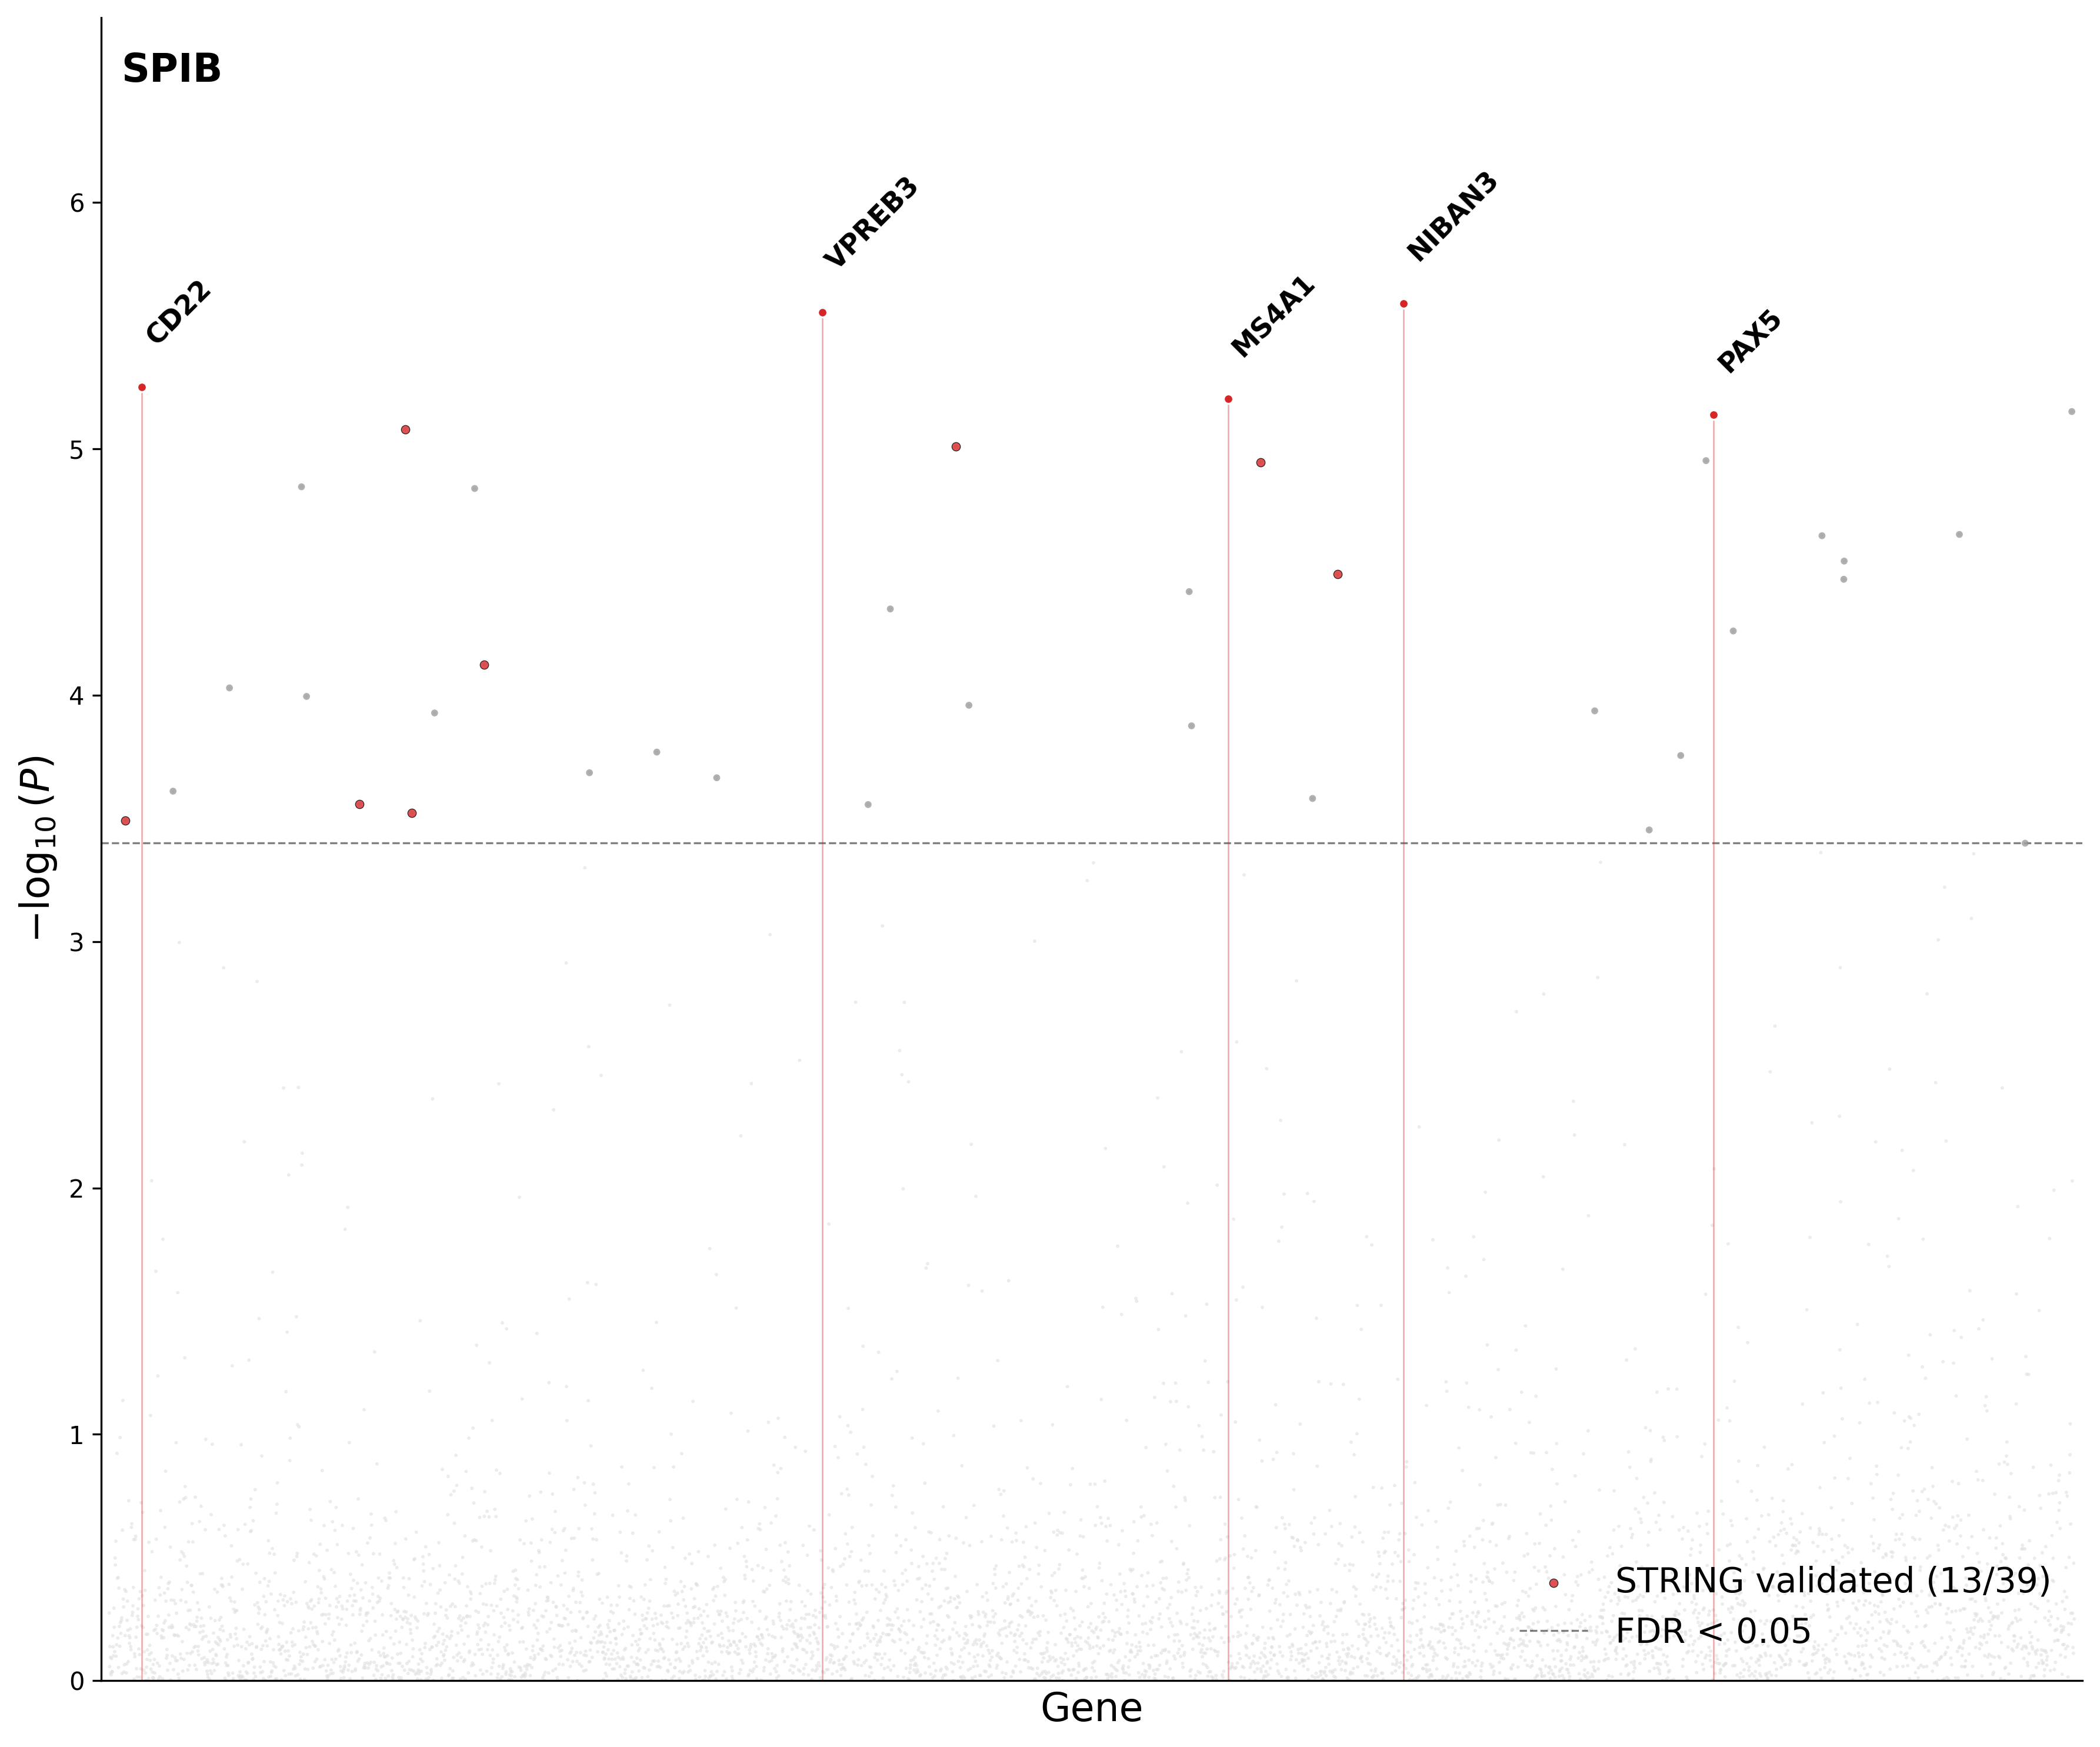


Results Summary for SPIB
Total significant genes (q < 0.05): 39
STRING-validated predictions: 13
Validation rate: 33.3%

Full results saved to: SPIB_interactions.csv

Analyzing MYBL2
Optimizing for MYBL2...
Testing 10 × 10 = 100 parameter combinations

New best: q=0.500, min_expr=0.010 → 18 significant genes (mean Z=3.79)
New best: q=0.500, min_expr=0.052 → 29 significant genes (mean Z=3.84)
New best: q=0.550, min_expr=0.052 → 31 significant genes (mean Z=3.88)

Optimal parameters:
  Quantile: 0.550
  Min expression freq: 0.052
  Significant genes (q<0.05): 31
  Total genes analyzed: 5204


Fetching STRING interactions for MYBL2...
Found 253 STRING interactions for MYBL2 (score >= 400)

STRING validation: 17/31 significant genes validated
Significant interactions (q < 0.05): 31


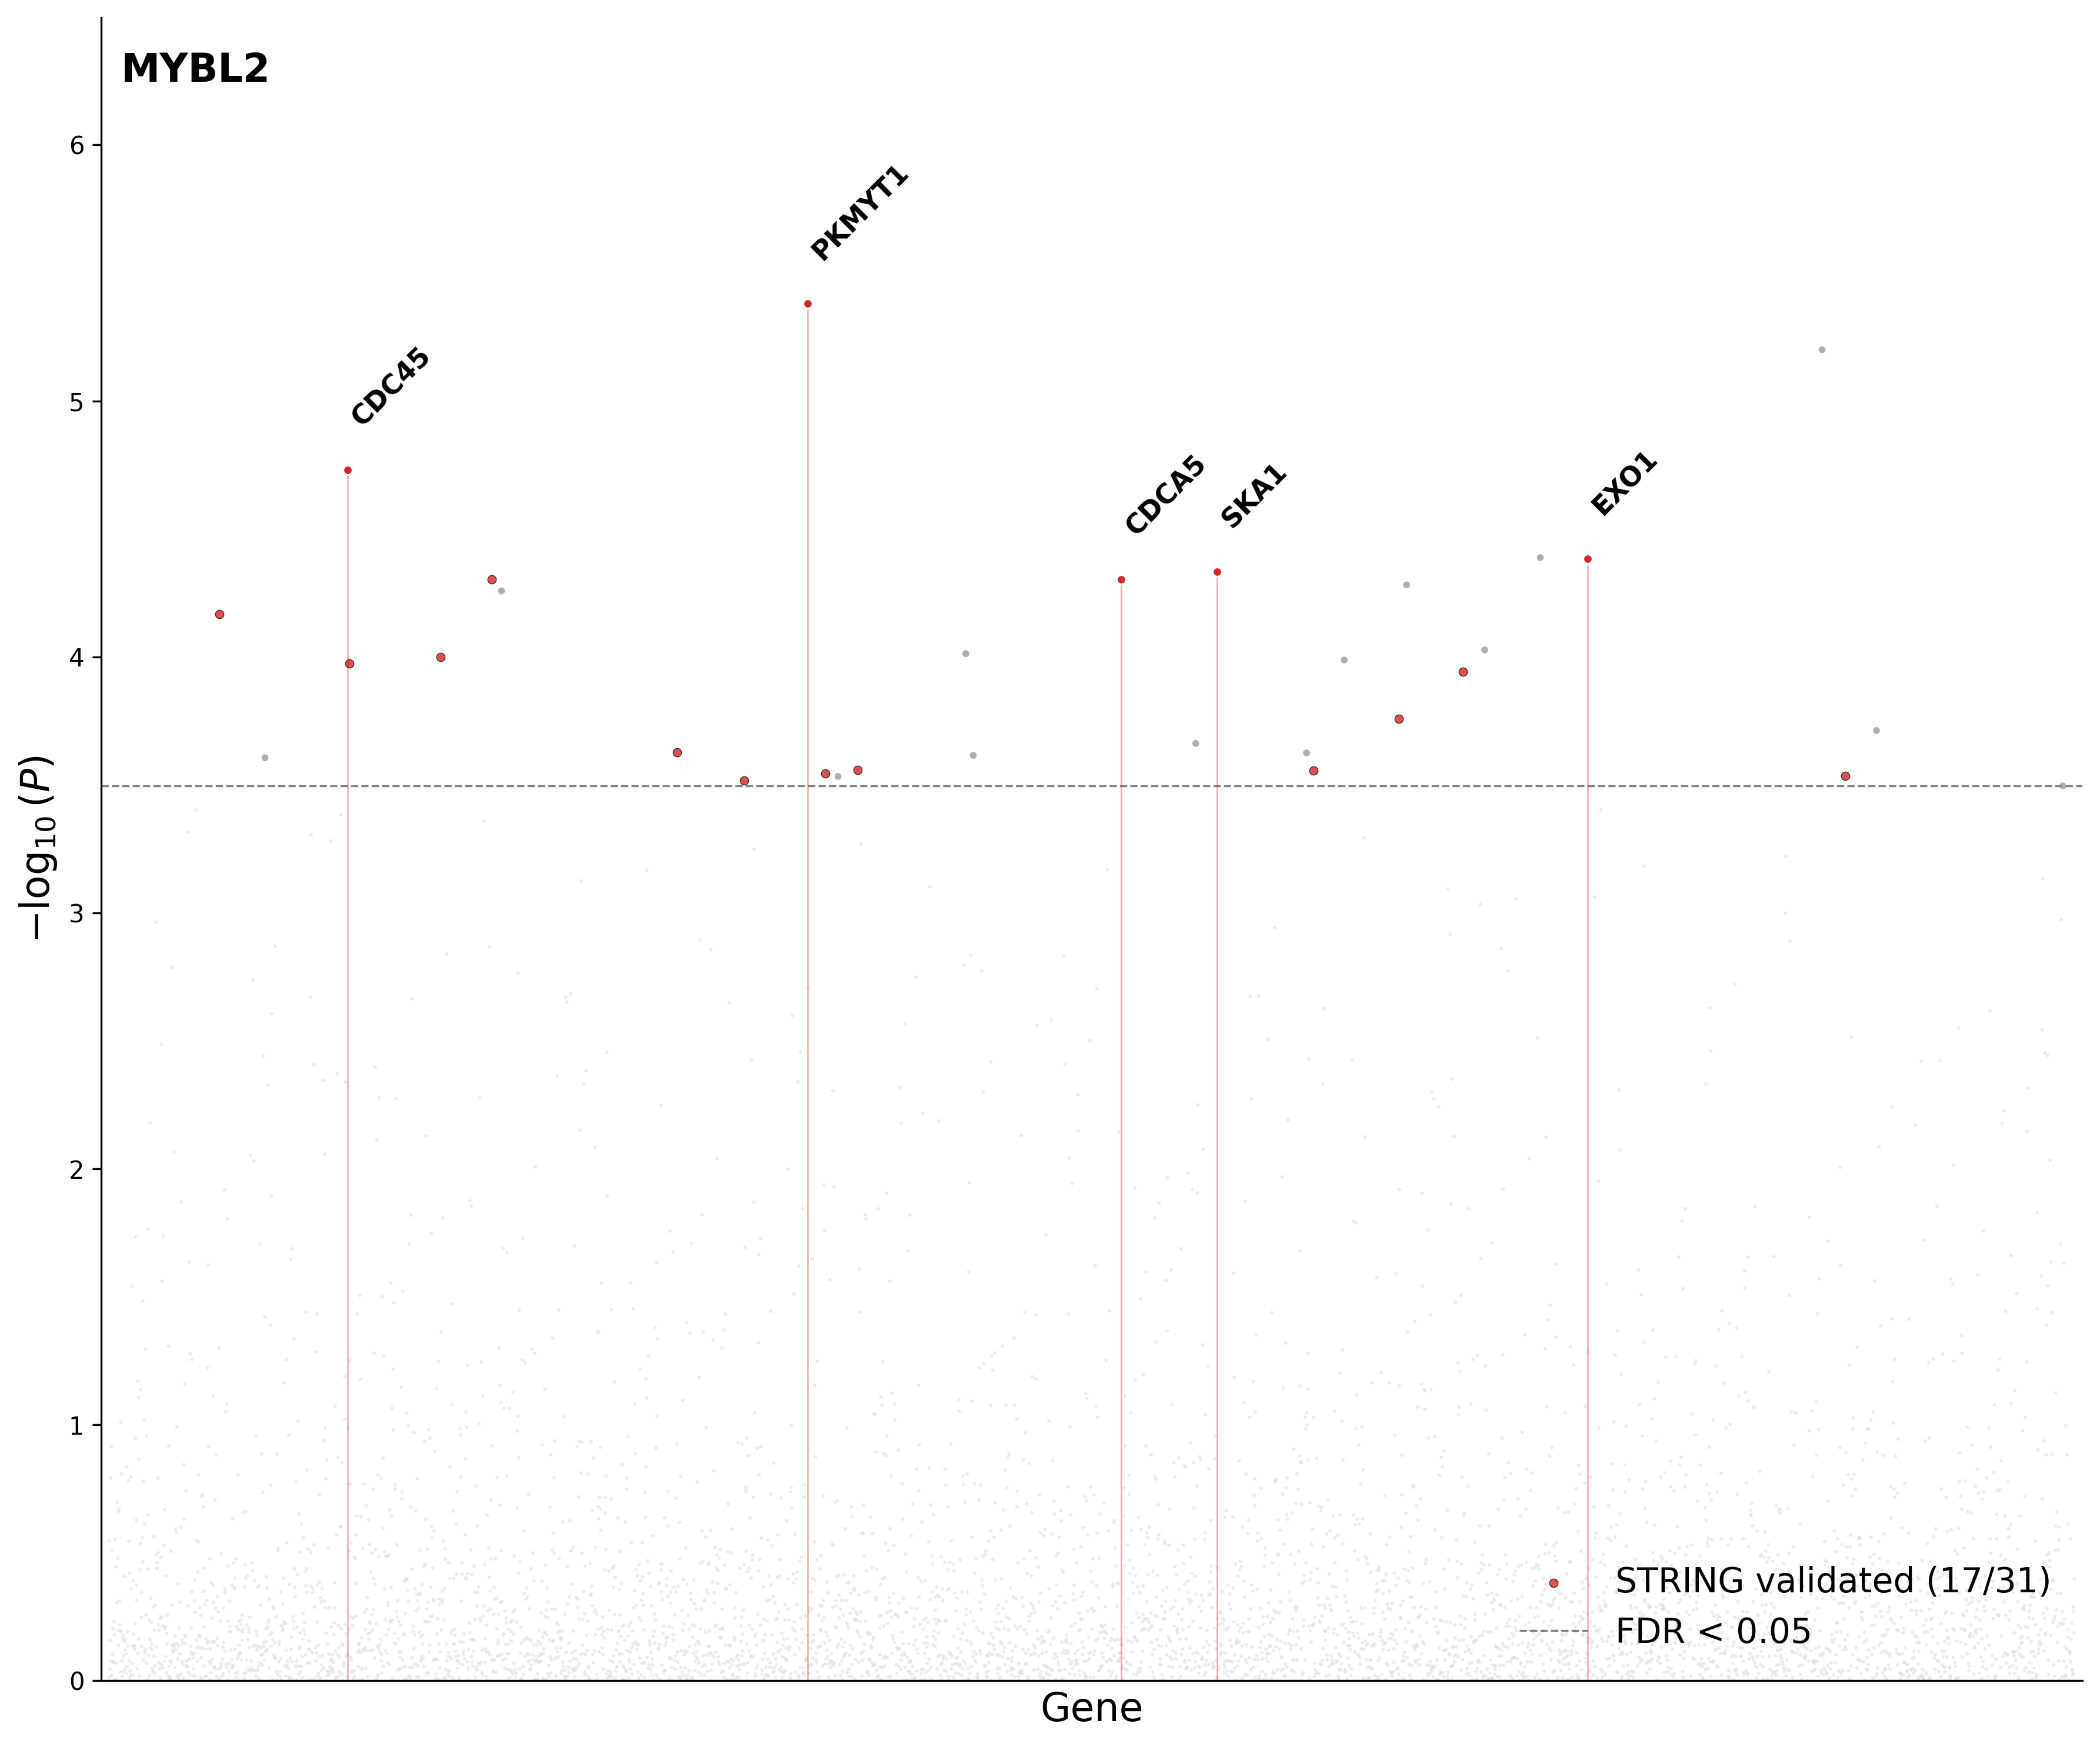


Results Summary for MYBL2
Total significant genes (q < 0.05): 31
STRING-validated predictions: 17
Validation rate: 54.8%

Full results saved to: MYBL2_interactions.csv

Analyzing PTTG1
Optimizing for PTTG1...
Testing 10 × 10 = 100 parameter combinations

New best: q=0.500, min_expr=0.010 → 0 significant genes (mean Z=0.00)
New best: q=0.500, min_expr=0.031 → 6 significant genes (mean Z=4.01)
New best: q=0.500, min_expr=0.052 → 23 significant genes (mean Z=4.00)
New best: q=0.500, min_expr=0.073 → 31 significant genes (mean Z=3.98)

Optimal parameters:
  Quantile: 0.500
  Min expression freq: 0.073
  Significant genes (q<0.05): 31
  Total genes analyzed: 4641


Fetching STRING interactions for PTTG1...
Found 250 STRING interactions for PTTG1 (score >= 400)

STRING validation: 27/31 significant genes validated
Significant interactions (q < 0.05): 31


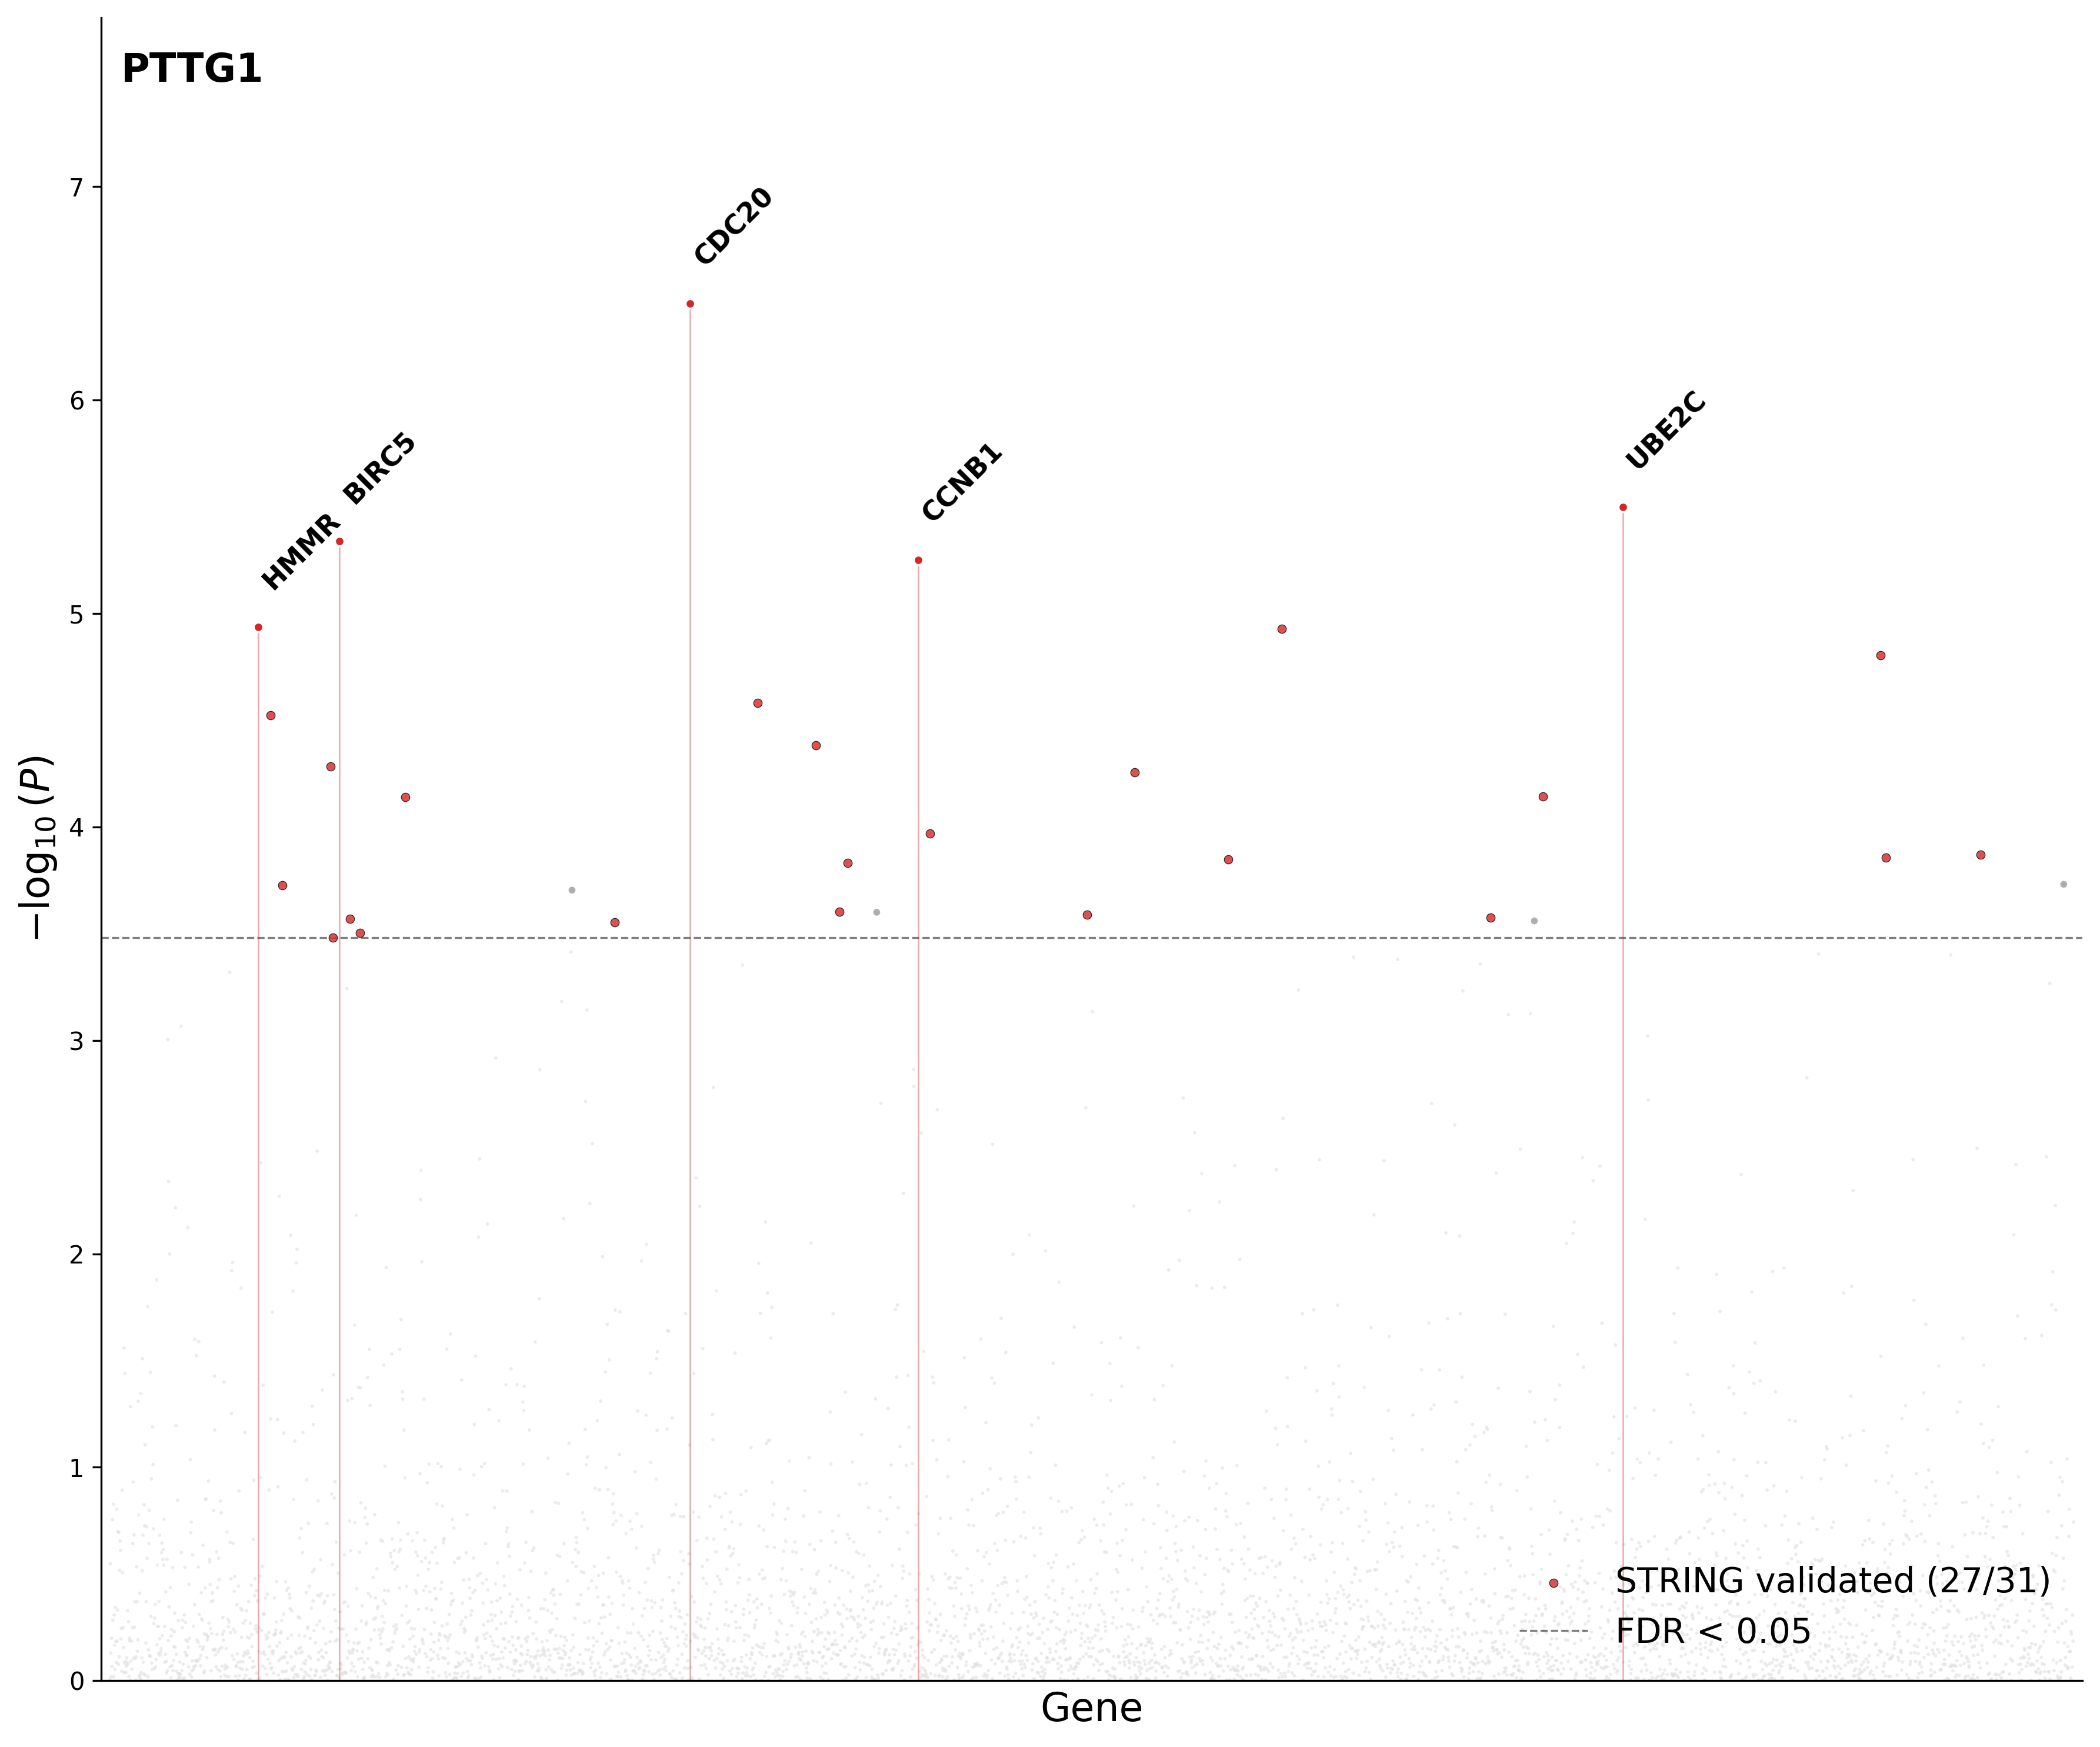


Results Summary for PTTG1
Total significant genes (q < 0.05): 31
STRING-validated predictions: 27
Validation rate: 87.1%

Full results saved to: PTTG1_interactions.csv

Analysis complete!


In [4]:
if __name__ == "__main__":
    target_tfs = ["E2F8", 'FOXM1', 'SPIB', 'MYBL2', 'PTTG1']
    
    for tf in target_tfs:
        if tf:
            print(f"\n{'='*70}")
            print(f"Analyzing {tf}")
            print('='*70)
            
            results_df, params = calculate_gene_interactions_auto(processed_df, tf, quantile_range=(0.5, 0.95), min_expr_range=(0.01, 0.2), search_resolution=10)
            
            
            print(f"\nFetching STRING interactions for {tf}...")
            string_interactors = get_string_interactions(tf, score_threshold=400, limit=1000)
            
            sig_genes, stats_ = plot_genes(
                results_df, 
                tf, 
                q_threshold=0.05,
                top_n=5,
                string_interactors=string_interactors, output_path = None
            )
            
            print(f"\n{'='*70}")
            print(f"Results Summary for {tf}")
            print('='*70)
            print(f"Total significant genes (q < 0.05): {stats_['total_significant']}")
            print(f"STRING-validated predictions: {stats_['string_validated']}")
            print(f"Validation rate: {stats_['validation_rate']:.1%}")
            
            output_file = f"{tf}_interactions.csv"
            results_df['in_STRING'] = results_df['gene'].isin(string_interactors)
            results_df.to_csv(output_file, index=False)
            print(f"\nFull results saved to: {output_file}")
            
        else:
            print(f"\n{tf} not found in dataset")
    
    print("\n" + "="*70)
    print("Analysis complete!")
    print("="*70)